# Imports

In [ ]:
!pip install keras_unet_collection

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 856.6 kB/s eta 0:00:00


In [ ]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
import glob
from datetime import datetime
from PIL import Image
import random
import tensorflow as tf

from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.metrics import MeanIoU

from keras_unet_collection import losses

from sklearn.model_selection import train_test_split

# Get dataset

In [ ]:
!wget -O augmented_dataset3200.zip https://www.dropbox.com/s/dbu916o3ki5fh5j/augmented_dataset3200.zip?dl=0
!unzip /content/augmented_dataset3200.zip

## Process images

In [ ]:
augmented_images_dir_path = "/content/augmented_images"
augmented_masks_dir_path =  "/content/augmented_masks"

In [ ]:
image_names = glob.glob(f"{augmented_images_dir_path}/*.jpg")
image_names.sort()


image_dataset = []

for image_name in image_names:
      image = cv2.imread(image_name, 1)
      image = Image.fromarray(image)
      image_dataset.append(np.array(image))

In [ ]:
mask_names = glob.glob(f"{augmented_masks_dir_path}/*.png")
mask_names.sort()

mask_dataset = []

for image_name in mask_names:
        image = cv2.imread(image_name, 0)
        image = np.where(image>0, 255, image)
        image = Image.fromarray(image)
        mask_dataset.append(np.array(image))

In [ ]:
names = []
for i in range(len(os.listdir(augmented_masks_dir_path))):
  img_name = image_names[i].split("/")[-1]
  mask_name = mask_names[i].split("/")[-1]

  n1 = img_name.split(".")[0]
  n2 = mask_name.split(".")[0]
  names.append(n1==n2)

all(names)

True

In [ ]:
image_dataset = np.array(image_dataset)/255.
mask_dataset = np.expand_dims((np.array(mask_dataset)),3) /255.

#Split data for train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 9)

In [ ]:
X_train.shape

(2560, 256, 256, 3)

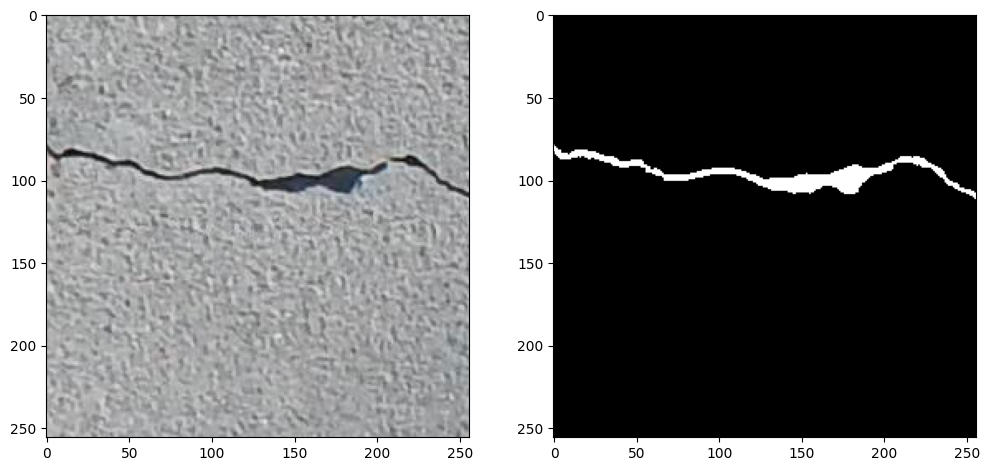

In [ ]:
#Sanity check
image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (256, 256, 3)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (256, 256)), cmap='gray')
plt.show()

# Attention U-Net

## Settings

In [ ]:
from keras_unet_collection import losses
metrics_set=[ tf.keras.metrics.BinaryIoU(target_class_ids=[1]), losses.dice_coef]

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]
input_shape = (IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS)
num_labels = 1  #Binary
batch_size = 16
epochs = 50

In [ ]:
!mkdir /content/att_unet_checkpoints

filepath = '/content/att_unet_checkpoints/attunet_model.h5'
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor="val_dice_coef",
                             verbose=1,
                             save_best_only=True,
                             mode="max")

earlyStopping = EarlyStopping(patience=5)

callbacks = [checkpoint, earlyStopping]

## Fitting

In [ ]:
from keras_unet_collection.models import att_unet_2d

In [ ]:
model = att_unet_2d((256, 256, 3),
                      filter_num=[64, 128, 256, 512, 1024],
                      n_labels=1,
                      stack_num_down=2,
                      stack_num_up=2, activation='ReLU',
                      atten_activation='ReLU'
                      , attention='add',
                      output_activation='Sigmoid',
                      batch_norm=True,
                      pool=False,
                      unpool=False,
                      backbone='VGG16',
                      weights='imagenet',
                      freeze_backbone=True,
                      freeze_batch_norm=True,
                      name='attunet'
                      )


In [ ]:
model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=metrics_set)

In [ ]:
start = datetime.now()
history = model.fit(X_train, y_train,
                    verbose=1,
                    batch_size = batch_size,
                    validation_data=(X_test, y_test ),
                    epochs=epochs,
                    callbacks=callbacks)

stop = datetime.now()

Epoch 1/50
160/160 [==============================] - ETA: 0s - loss: 0.1601 - binary_io_u: 0.2597 - dice_coef: 0.1245
Epoch 1: val_dice_coef improved from -inf to 0.04687, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 82s 365ms/step - loss: 0.1601 - binary_io_u: 0.2597 - dice_coef: 0.1245 - val_loss: 0.3523 - val_binary_io_u: 0.6286 - val_dice_coef: 0.0469
Epoch 2/50
160/160 [==============================] - ETA: 0s - loss: 0.0666 - binary_io_u: 0.6676 - dice_coef: 0.2305
Epoch 2: val_dice_coef improved from 0.04687 to 0.15661, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 53s 330ms/step - loss: 0.0666 - binary_io_u: 0.6676 - dice_coef: 0.2305 - val_loss: 0.1046 - val_binary_io_u: 0.7004 - val_dice_coef: 0.1566
Epoch 3/50
160/160 [==============================] - ETA: 0s - loss: 0.0497 - binary_io_u: 0.7113 - dice_coef: 0.3006
Epoch 3: val_dice_coef improved from 0.15661 to 0.27140, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 59s 367ms/step - loss: 0.0497 - binary_io_u: 0.7113 - dice_coef: 0.3006 - val_loss: 0.0495 - val_binary_io_u: 0.6889 - val_dice_coef: 0.2714
Epoch 4/50
160/160 [==============================] - ETA: 0s - loss: 0.0407 - binary_io_u: 0.7310 - dice_coef: 0.3523
Epoch 4: val_dice_coef improved from 0.27140 to 0.33832, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 57s 355ms/step - loss: 0.0407 - binary_io_u: 0.7310 - dice_coef: 0.3523 - val_loss: 0.0395 - val_binary_io_u: 0.7211 - val_dice_coef: 0.3383
Epoch 5/50
160/160 [==============================] - ETA: 0s - loss: 0.0337 - binary_io_u: 0.7477 - dice_coef: 0.4016
Epoch 5: val_dice_coef improved from 0.33832 to 0.41079, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 56s 351ms/step - loss: 0.0337 - binary_io_u: 0.7477 - dice_coef: 0.4016 - val_loss: 0.0312 - val_binary_io_u: 0.7477 - val_dice_coef: 0.4108
Epoch 6/50
160/160 [==============================] - ETA: 0s - loss: 0.0287 - binary_io_u: 0.7557 - dice_coef: 0.4466
Epoch 6: val_dice_coef improved from 0.41079 to 0.43630, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 54s 341ms/step - loss: 0.0287 - binary_io_u: 0.7557 - dice_coef: 0.4466 - val_loss: 0.0274 - val_binary_io_u: 0.7368 - val_dice_coef: 0.4363
Epoch 7/50
160/160 [==============================] - ETA: 0s - loss: 0.0254 - binary_io_u: 0.7564 - dice_coef: 0.4809
Epoch 7: val_dice_coef improved from 0.43630 to 0.48989, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 58s 366ms/step - loss: 0.0254 - binary_io_u: 0.7564 - dice_coef: 0.4809 - val_loss: 0.0239 - val_binary_io_u: 0.7529 - val_dice_coef: 0.4899
Epoch 8/50
160/160 [==============================] - ETA: 0s - loss: 0.0222 - binary_io_u: 0.7648 - dice_coef: 0.5154
Epoch 8: val_dice_coef improved from 0.48989 to 0.53429, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 60s 378ms/step - loss: 0.0222 - binary_io_u: 0.7648 - dice_coef: 0.5154 - val_loss: 0.0204 - val_binary_io_u: 0.7548 - val_dice_coef: 0.5343
Epoch 9/50
160/160 [==============================] - ETA: 0s - loss: 0.0198 - binary_io_u: 0.7682 - dice_coef: 0.5504
Epoch 9: val_dice_coef improved from 0.53429 to 0.54775, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 57s 358ms/step - loss: 0.0198 - binary_io_u: 0.7682 - dice_coef: 0.5504 - val_loss: 0.0193 - val_binary_io_u: 0.7507 - val_dice_coef: 0.5477
Epoch 10/50
160/160 [==============================] - ETA: 0s - loss: 0.0178 - binary_io_u: 0.7731 - dice_coef: 0.5794
Epoch 10: val_dice_coef improved from 0.54775 to 0.59252, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 59s 368ms/step - loss: 0.0178 - binary_io_u: 0.7731 - dice_coef: 0.5794 - val_loss: 0.0170 - val_binary_io_u: 0.7582 - val_dice_coef: 0.5925
Epoch 11/50
160/160 [==============================] - ETA: 0s - loss: 0.0162 - binary_io_u: 0.7763 - dice_coef: 0.6082
Epoch 11: val_dice_coef improved from 0.59252 to 0.61812, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 55s 342ms/step - loss: 0.0162 - binary_io_u: 0.7763 - dice_coef: 0.6082 - val_loss: 0.0153 - val_binary_io_u: 0.7597 - val_dice_coef: 0.6181
Epoch 12/50
160/160 [==============================] - ETA: 0s - loss: 0.0150 - binary_io_u: 0.7787 - dice_coef: 0.6274
Epoch 12: val_dice_coef improved from 0.61812 to 0.62214, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 58s 363ms/step - loss: 0.0150 - binary_io_u: 0.7787 - dice_coef: 0.6274 - val_loss: 0.0148 - val_binary_io_u: 0.7537 - val_dice_coef: 0.6221
Epoch 13/50
160/160 [==============================] - ETA: 0s - loss: 0.0137 - binary_io_u: 0.7833 - dice_coef: 0.6514
Epoch 13: val_dice_coef improved from 0.62214 to 0.65141, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 57s 354ms/step - loss: 0.0137 - binary_io_u: 0.7833 - dice_coef: 0.6514 - val_loss: 0.0138 - val_binary_io_u: 0.7584 - val_dice_coef: 0.6514
Epoch 14/50
160/160 [==============================] - ETA: 0s - loss: 0.0130 - binary_io_u: 0.7828 - dice_coef: 0.6693
Epoch 14: val_dice_coef did not improve from 0.65141
160/160 [==============================] - 55s 344ms/step - loss: 0.0130 - binary_io_u: 0.7828 - dice_coef: 0.6693 - val_loss: 0.0607 - val_binary_io_u: 0.4092 - val_dice_coef: 0.2714
Epoch 15/50
160/160 [==============================] - ETA: 0s - loss: 0.0125 - binary_io_u: 0.7797 - dice_coef: 0.6826
Epoch 15: val_dice_coef improved from 0.65141 to 0.68647, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 56s 350ms/step - loss: 0.0125 - binary_io_u: 0.7797 - dice_coef: 0.6826 - val_loss: 0.0122 - val_binary_io_u: 0.7576 - val_dice_coef: 0.6865
Epoch 16/50
160/160 [==============================] - ETA: 0s - loss: 0.0115 - binary_io_u: 0.7866 - dice_coef: 0.7033
Epoch 16: val_dice_coef improved from 0.68647 to 0.69777, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 56s 349ms/step - loss: 0.0115 - binary_io_u: 0.7866 - dice_coef: 0.7033 - val_loss: 0.0119 - val_binary_io_u: 0.7647 - val_dice_coef: 0.6978
Epoch 17/50
160/160 [==============================] - ETA: 0s - loss: 0.0108 - binary_io_u: 0.7914 - dice_coef: 0.7187
Epoch 17: val_dice_coef improved from 0.69777 to 0.70729, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 56s 353ms/step - loss: 0.0108 - binary_io_u: 0.7914 - dice_coef: 0.7187 - val_loss: 0.0115 - val_binary_io_u: 0.7576 - val_dice_coef: 0.7073
Epoch 18/50
160/160 [==============================] - ETA: 0s - loss: 0.0103 - binary_io_u: 0.7921 - dice_coef: 0.7328
Epoch 18: val_dice_coef improved from 0.70729 to 0.72300, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 55s 343ms/step - loss: 0.0103 - binary_io_u: 0.7921 - dice_coef: 0.7328 - val_loss: 0.0108 - val_binary_io_u: 0.7618 - val_dice_coef: 0.7230
Epoch 19/50
160/160 [==============================] - ETA: 0s - loss: 0.0097 - binary_io_u: 0.7964 - dice_coef: 0.7447
Epoch 19: val_dice_coef improved from 0.72300 to 0.73400, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 54s 341ms/step - loss: 0.0097 - binary_io_u: 0.7964 - dice_coef: 0.7447 - val_loss: 0.0105 - val_binary_io_u: 0.7616 - val_dice_coef: 0.7340
Epoch 20/50
160/160 [==============================] - ETA: 0s - loss: 0.0094 - binary_io_u: 0.7979 - dice_coef: 0.7554
Epoch 20: val_dice_coef improved from 0.73400 to 0.73938, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 55s 345ms/step - loss: 0.0094 - binary_io_u: 0.7979 - dice_coef: 0.7554 - val_loss: 0.0105 - val_binary_io_u: 0.7623 - val_dice_coef: 0.7394
Epoch 21/50
160/160 [==============================] - ETA: 0s - loss: 0.0090 - binary_io_u: 0.7999 - dice_coef: 0.7638
Epoch 21: val_dice_coef improved from 0.73938 to 0.75498, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 56s 350ms/step - loss: 0.0090 - binary_io_u: 0.7999 - dice_coef: 0.7638 - val_loss: 0.0103 - val_binary_io_u: 0.7634 - val_dice_coef: 0.7550
Epoch 22/50
160/160 [==============================] - ETA: 0s - loss: 0.0092 - binary_io_u: 0.7909 - dice_coef: 0.7633
Epoch 22: val_dice_coef did not improve from 0.75498
160/160 [==============================] - 47s 292ms/step - loss: 0.0092 - binary_io_u: 0.7909 - dice_coef: 0.7633 - val_loss: 0.0234 - val_binary_io_u: 0.6770 - val_dice_coef: 0.5378
Epoch 23/50
160/160 [==============================] - ETA: 0s - loss: 0.0090 - binary_io_u: 0.7879 - dice_coef: 0.7693
Epoch 23: val_dice_coef improved from 0.75498 to 0.75703, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 60s 373ms/step - loss: 0.0090 - binary_io_u: 0.7879 - dice_coef: 0.7693 - val_loss: 0.0098 - val_binary_io_u: 0.7601 - val_dice_coef: 0.7570
Epoch 24/50
160/160 [==============================] - ETA: 0s - loss: 0.0086 - binary_io_u: 0.7934 - dice_coef: 0.7778
Epoch 24: val_dice_coef improved from 0.75703 to 0.76553, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 59s 367ms/step - loss: 0.0086 - binary_io_u: 0.7934 - dice_coef: 0.7778 - val_loss: 0.0098 - val_binary_io_u: 0.7627 - val_dice_coef: 0.7655
Epoch 25/50
160/160 [==============================] - ETA: 0s - loss: 0.0081 - binary_io_u: 0.8029 - dice_coef: 0.7894
Epoch 25: val_dice_coef improved from 0.76553 to 0.77211, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 54s 338ms/step - loss: 0.0081 - binary_io_u: 0.8029 - dice_coef: 0.7894 - val_loss: 0.0096 - val_binary_io_u: 0.7624 - val_dice_coef: 0.7721
Epoch 26/50
160/160 [==============================] - ETA: 0s - loss: 0.0077 - binary_io_u: 0.8076 - dice_coef: 0.7989
Epoch 26: val_dice_coef improved from 0.77211 to 0.77512, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 53s 332ms/step - loss: 0.0077 - binary_io_u: 0.8076 - dice_coef: 0.7989 - val_loss: 0.0095 - val_binary_io_u: 0.7564 - val_dice_coef: 0.7751
Epoch 27/50
160/160 [==============================] - ETA: 0s - loss: 0.0075 - binary_io_u: 0.8112 - dice_coef: 0.8058
Epoch 27: val_dice_coef improved from 0.77512 to 0.78455, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 55s 343ms/step - loss: 0.0075 - binary_io_u: 0.8112 - dice_coef: 0.8058 - val_loss: 0.0093 - val_binary_io_u: 0.7616 - val_dice_coef: 0.7846
Epoch 28/50
160/160 [==============================] - ETA: 0s - loss: 0.0071 - binary_io_u: 0.8163 - dice_coef: 0.8142
Epoch 28: val_dice_coef improved from 0.78455 to 0.78849, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 60s 376ms/step - loss: 0.0071 - binary_io_u: 0.8163 - dice_coef: 0.8142 - val_loss: 0.0093 - val_binary_io_u: 0.7613 - val_dice_coef: 0.7885
Epoch 29/50
160/160 [==============================] - ETA: 0s - loss: 0.0070 - binary_io_u: 0.8181 - dice_coef: 0.8183
Epoch 29: val_dice_coef improved from 0.78849 to 0.79775, saving model to /content/att_unet_checkpoints/attunet_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 55s 347ms/step - loss: 0.0070 - binary_io_u: 0.8181 - dice_coef: 0.8183 - val_loss: 0.0093 - val_binary_io_u: 0.7596 - val_dice_coef: 0.7978
Epoch 30/50
160/160 [==============================] - ETA: 0s - loss: 0.0067 - binary_io_u: 0.8224 - dice_coef: 0.8244
Epoch 30: val_dice_coef did not improve from 0.79775
160/160 [==============================] - 52s 328ms/step - loss: 0.0067 - binary_io_u: 0.8224 - dice_coef: 0.8244 - val_loss: 0.0094 - val_binary_io_u: 0.7553 - val_dice_coef: 0.7930
Epoch 31/50
160/160 [==============================] - ETA: 0s - loss: 0.0065 - binary_io_u: 0.8271 - dice_coef: 0.8328
Epoch 31: val_dice_coef did not improve from 0.79775
160/160 [==============================] - 57s 354ms/step - loss: 0.0065 - binary_io_u: 0.8271 - dice_coef: 0.8328 - val_loss: 0.0100 - val_binary_io_u: 0.7503 - val_dice_coef: 0.7940
Epoch 32/50
160/160 [==============================] - ETA: 0s - loss: 0.0062 - binary_io_u: 0.8320 - 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


160/160 [==============================] - 53s 334ms/step - loss: 0.0062 - binary_io_u: 0.8310 - dice_coef: 0.8397 - val_loss: 0.0097 - val_binary_io_u: 0.7520 - val_dice_coef: 0.8013


In [ ]:
print(f"Execution time: {stop-start}")

Execution time: 0:31:21.210388


# Training history

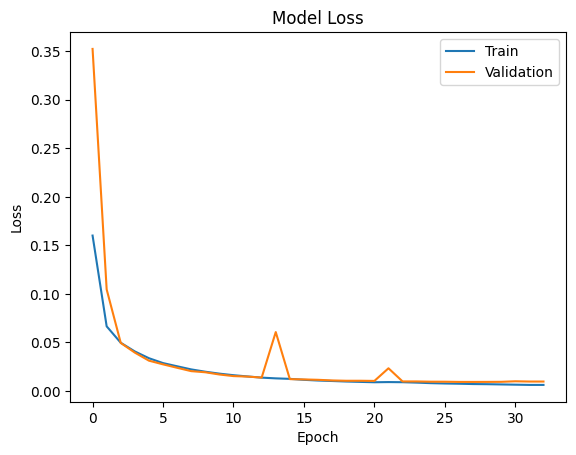

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

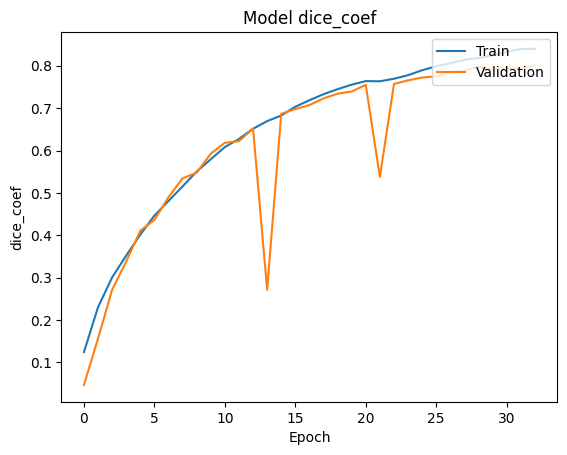

In [ ]:
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.xlabel('Epoch')
plt.ylabel('dice_coef')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

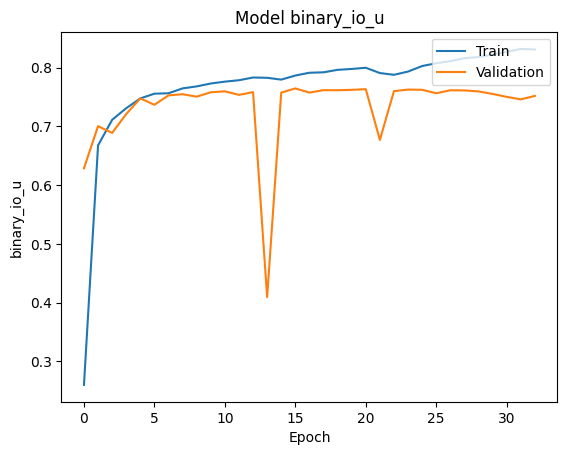

In [ ]:
plt.plot(history.history['binary_io_u'])
plt.plot(history.history['val_binary_io_u'])
plt.title('Model binary_io_u')
plt.xlabel('Epoch')
plt.ylabel('binary_io_u')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

# Metrics

## Ground truth vs prediction

1/1 [==============================] - 1s 619ms/step


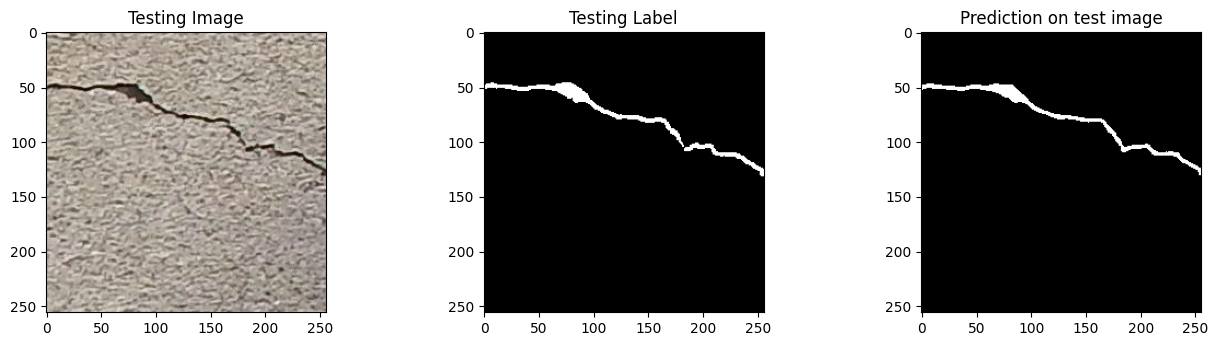

In [ ]:
import random
test_img_number = random.randint(0, X_test.shape[0]-1)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]

test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img, cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='gray')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, cmap='gray')

plt.show()

## IoU for test dataset

In [ ]:
import pandas as pd
n_classes = 2

IoU_values = []
for img in range(0, X_test.shape[0]):
    temp_img = X_test[img]
    ground_truth=y_test[img]
    temp_img_input=np.expand_dims(temp_img, 0)
    prediction = (model.predict(temp_img_input)[0,:,:,0] > 0.5).astype(np.uint8)

    IoU = MeanIoU(num_classes=n_classes)
    IoU.update_state(ground_truth[:,:,0], prediction)
    IoU = IoU.result().numpy()
    IoU_values.append(IoU)

df = pd.DataFrame(IoU_values, columns=["IoU"])
df = df[df.IoU != 1.0]
mean_IoU = df.mean().values

In [ ]:
print(f"Mean IoU for test dataset is: {round(mean_IoU[0]*100,2)}%")

Mean IoU for test dataset is: 85.59%


## Probability map

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

def ax_decorate_box(ax):
    [j.set_linewidth(0) for j in ax.spines.values()]
    ax.tick_params(axis="both", which="both", bottom=False, top=False, \
               labelbottom=False, left=False, right=False, labelleft=False)
    return ax

In [ ]:
y_pred = model.predict([X_test])

20/20 [==============================] - 13s 180ms/step


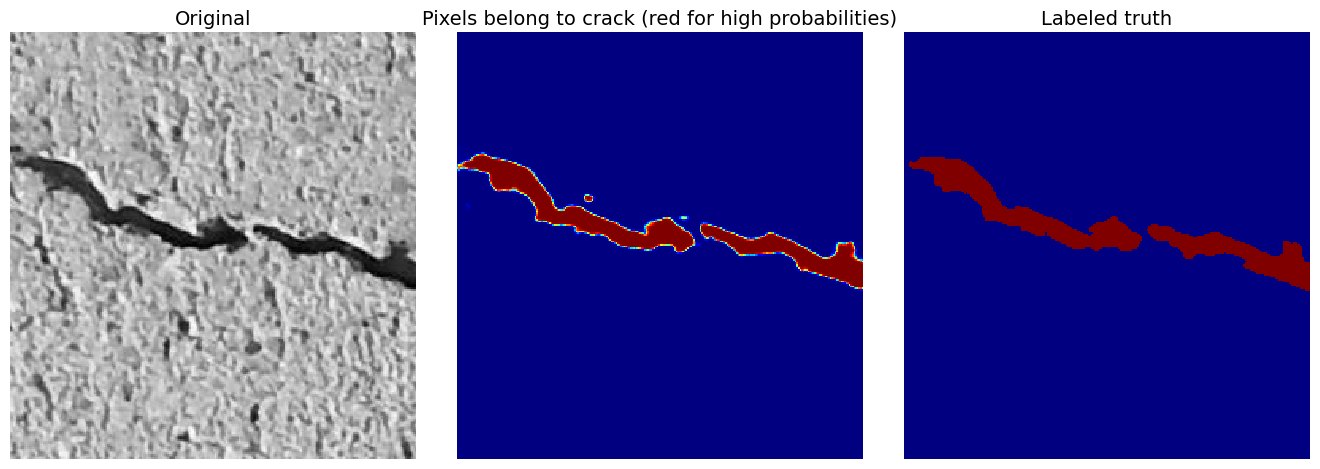

In [ ]:
i_sample = random.randint(0, X_test.shape[0]-1)

fig, AX = plt.subplots(1, 3, figsize=(13, (13-0.2)/3))
plt.subplots_adjust(0, 0, 1, 1, hspace=0, wspace=0.1)
for ax in AX:
    ax = ax_decorate_box(ax)
AX[0].pcolormesh(np.mean(X_test[i_sample, ...,], axis=-1), cmap=plt.cm.gray)
AX[1].pcolormesh(y_pred[i_sample, ..., 0], cmap=plt.cm.jet)
AX[2].pcolormesh(y_test[i_sample, ..., 0], cmap=plt.cm.jet)

AX[0].set_title("Original", fontsize=14);
AX[1].set_title("Pixels belong to crack (red for high probabilities)", fontsize=14);
AX[2].set_title("Labeled truth", fontsize=14);